## ELETTRA-05: ID linear optics distortion

In [1]:
# In this example effects of an ID (APPLE-II device represented by a linear 4x4 symplectic matrix) are presented
# ID is inserted replacing a selected marker and the drifts around it are adjuced

# The following effects on the linear optics are investigated:

# -- Tune shifts
# -- Dispersion
# -- Beta beating
# -- Coupling (minimal tune distance)

# ID is modeled as a linear element
# Corresponding transport matrix is M = exp(S A) exp(dp S B)

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.quadrupole import Quadrupole
from model.library.matrix import Matrix

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Merge drifts

ring.merge()

# Change lattice start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice lattice

ring.splice()

# Describe

ring.describe

{'BPM': 168, 'Drift': 708, 'Dipole': 156, 'Quadrupole': 360, 'Marker': 12}

In [6]:
# Compute tunes (fractional part)

nux, nuy = tune(ring, [], matched=True, limit=1)

In [7]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx, etapx, etaqy, etapy = dispersion(ring, orbit, [], limit=1)

In [8]:
# Compute twiss parameters

ax, bx, ay, by = twiss(ring, [], matched=True, advance=True, full=False).T

In [9]:
# Compute phase advances

mux, muy = advance(ring, [], alignment=False, matched=True).T

In [10]:
# Compute coupling

c = coupling(ring, [])

In [11]:
# Define ID model
# Note, only the flattened triangular part of the A and B matrices is passed

A = torch.tensor([[-0.033672116808046514, 0.00009820585977319643, 7.997178435260394E-8, 0.001463415552946162],
                  [0.00009820585977272547, 6.069853084551595, 0.0019638839107469735, 5.87111869509966E-7],
                  [7.997178432553901E-8, 0.0019638839107470963, 0.06034925071344756, 0.00013255713638205438],
                  [0.0014634155529458786, 5.871118691822303E-7, 0.0001325571363821035, 5.915344901230816]], dtype=dtype)

B = torch.tensor([[0.03284941470655345, -0.004761855170634861, 0.000013787596685030976, -0.002914608677271122],
                  [-0.004761855170634861, -6.1983149144711325, -0.0038145315898986286, -0.010225544365155104],
                  [0.000013787596685030976, -0.0038145315898986286, -0.062319184642460224, -0.012416413680349264],
                  [-0.002914608677271122, -0.010225544365155104, -0.012416413680349264, -5.764147760480357]], dtype=dtype)

ID = Matrix('ID', 
            length=6.0144, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist(), 
            B=B[torch.triu(torch.ones_like(B, dtype=torch.bool))].tolist())

In [12]:
# Insert ID into the existing lattice
# This will replace the target marker

ring.flatten()
ring.insert(ID, 'MLL_S01', position=0.0)
ring.splice()

# Describe

ring.describe

{'BPM': 168,
 'Drift': 708,
 'Dipole': 156,
 'Quadrupole': 360,
 'Matrix': 1,
 'Marker': 11}

In [13]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(ring, [], matched=True, limit=1)

In [14]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_id, etapx_id, etaqy_id, etapy_id = dispersion(ring, orbit, [], limit=1)

In [15]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(ring, [], matched=True, advance=True, full=False).T

In [16]:
# Compute phase advances

mux_id, muy_id = advance(ring, [], alignment=False, matched=True).T

In [17]:
# Compute coupling

c_id = coupling(ring, [])

In [18]:
# Tune shifts

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())

tensor(0.0260, dtype=torch.float64)
tensor(0.0114, dtype=torch.float64)


In [19]:
# Coupling (minimal tune distance)

print(c)
print(c_id)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)


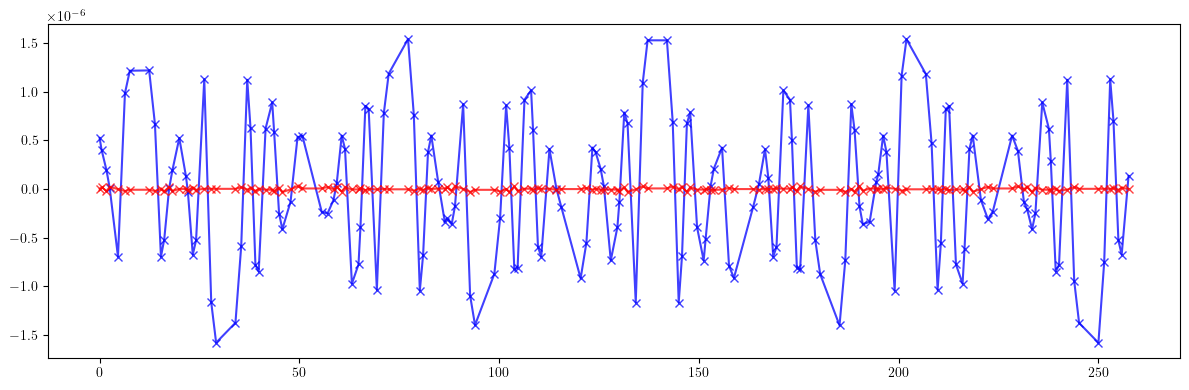

In [20]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

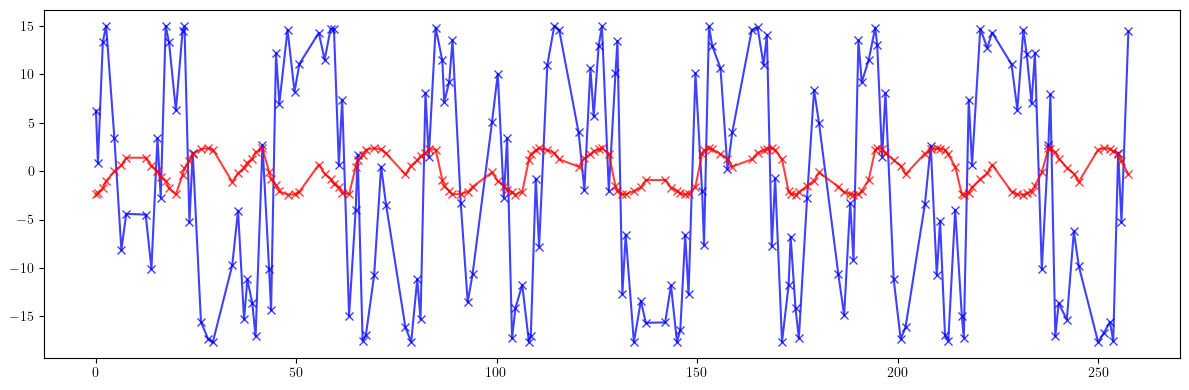

tensor(11.5997, dtype=torch.float64)
tensor(1.7847, dtype=torch.float64)


In [21]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())

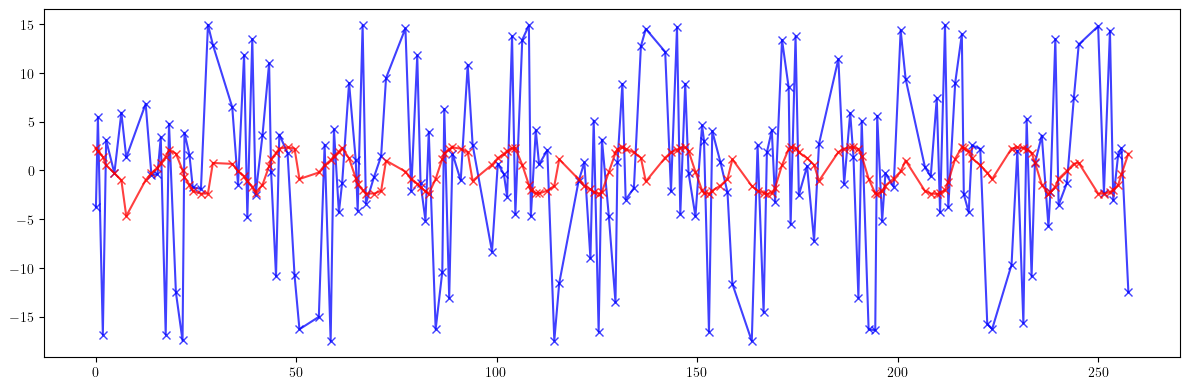

tensor(8.7942, dtype=torch.float64)
tensor(1.7713, dtype=torch.float64)


In [22]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())